In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
#下一行可以让数据集在单元格中嵌入化显示
%matplotlib inline

In [2]:
#读取数据
dataset_test = pd.read_csv('data/testdata.csv')
dataset_train = pd.read_csv('data/traindata.csv')

In [5]:
#先分开取出训练集的男女数据
dataset_male_train = dataset_train[dataset_train['gender'] == 'Male']
dataset_female_train = dataset_train[dataset_train['gender'] == 'Female']

#分别提取男女的身高体重特征
body_male_train = dataset_male_train[['height','weight']]
body_female_train = dataset_female_train[['height','weight']]

In [6]:
#最大似然估计
male_data = body_male_train.describe()
female_data = body_female_train.describe()

male_result = {}
male_result['height_mean'] = male_data['height'].mean()
male_result['height_sig'] = male_data['height'].std()
male_result['weight_mean'] = male_data['weight'].mean()
male_result['weight_sig'] = male_data['weight'].std()

female_result = {}
female_result['height_mean'] = female_data['height'].mean()
female_result['height_sig'] = female_data['height'].std()
female_result['weight_mean'] = female_data['weight'].mean()
female_result['weight_sig'] = female_data['weight'].std()

print('男生参数:\n\t\t身高\t\t\t体重\n平均值\t{}\t{}\n标准差\t{}\t{}\n'. 
      format(male_result['height_mean'], male_result['weight_mean'], 
             male_result['height_sig'], male_result['weight_sig']))
print('女生参数:\n\t\t身高\t\t\t体重\n平均值\t{}\t{}\n标准差\t{}\t{}'. 
      format(female_result['height_mean'], female_result['weight_mean'], 
             female_result['height_sig'], female_result['weight_sig']))

男生参数:
		身高			体重
平均值	137.760274566641	57.91795779218791
方差	4862.5083883028765	552.6063858235477

女生参数:
		身高			体重
平均值	127.46989618434571	46.176657628860255
方差	4014.777270457238	313.2768508250514


In [7]:
#贝叶斯估计
mean0 = 0
sig0 = 1
count = {}
count['Total'] = dataset_train.shape[0]
count['Male'] = dataset_male_train.shape[0]
count['Female'] = dataset_female_train.shape[0]

male_result['height_mean_bayes'] = (1/(count['Male']+male_result['height_sig']))*(body_male_train['height'].sum())
male_result['weight_mean_bayes'] = (1/(count['Male']+male_result['weight_sig']))*(body_male_train['weight'].sum())

female_result['height_mean_bayes'] = (1/(count['Female']+female_result['height_sig']))*(body_female_train['height'].sum())
female_result['weight_mean_bayes'] = (1/(count['Female']+female_result['weight_sig']))*(body_female_train['weight'].sum())

print('男生参数:\n\t\t身高\t\t\t体重\n均值\t{}\t{}\n'.
      format(male_result['height_mean_bayes'], male_result['weight_mean_bayes']))
print('女生参数:\n\t\t身高\t\t\t体重\n均值\t{}\t{}\n'.
      format(female_result['height_mean_bayes'], female_result['weight_mean_bayes']))

男生参数:
		身高			体重
均值	1.7723532077281405	5.526658990592229

女生参数:
		身高			体重
均值	1.9807973387664375	7.151019929015685



决策面

In [8]:
#先验概率
P_male = count['Male']/count['Total']
P_female = 1-P_male

In [9]:
#协方差矩阵
male_array = np.array(body_male_train)
female_array = np.array(body_female_train)
sig_male = np.cov(male_array.T)
sig_female = np.cov(female_array.T)

In [10]:
#均值
mean_male = np.array([male_result['height_mean'], male_result['weight_mean']]).reshape(-1, 1)
mean_female = np.array([female_result['height_mean'], female_result['weight_mean']]).reshape(-1, 1)

C:\Users\95826\AppData\Local\Temp\ipykernel_15404\1585330784.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample[i, j] = 1/2 * (a1 - a2) + 1/2 * a3 - a4


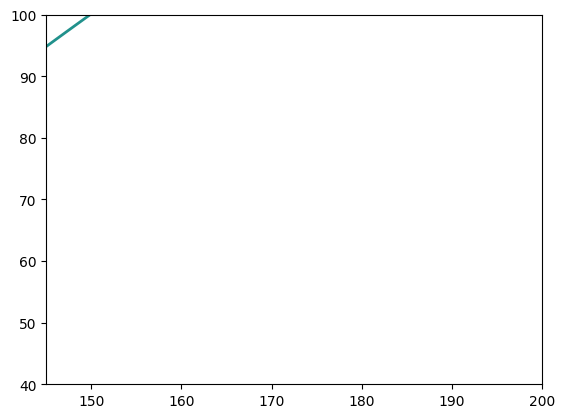

In [16]:
sample_height = np.linspace(145, 200)
sample_weight = np.linspace(40, 100)
sample = np.zeros((50, 50))
for i in range(50):
    for j in range(50):
        '''sample[i,j] = 0.5 * (np.dot(np.dot((x-mean_male).T,np.linalg.inv(sig_male)), (x-mean_male)) -\
        np.dot(np.dot((x-mean_female).T,np.linalg.inv(sig_female)), (x-mean_female))) +\
        0.5 * math.log(np.linalg.det(sig_male)/np.linalg.det(sig_female)) - math.log(P_male/P_female)'''

plt.contour(sample_height, sample_weight, sample, 0, linewidths=2)